### HPO on AWS SageMaker

- Our task is to use HPO to find the most ''optimal'' values for the parameters: batch size, epochs, learning rate, and dense-layer.
- In this demo, I will use Tensorflow 2.

Download the data

In [2]:
import os
import keras
import numpy as np
from keras.datasets import fashion_mnist

(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

Using TensorFlow backend.



4423680/4422102 [==============================] - 1s 0us/step


We create a local directory and save the training and test data seoerately

In [3]:
os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_val, label=y_val)    

### Train the model on the local instance



In [4]:

import sagemaker

print(sagemaker.__version__)
sess = sagemaker.Session() 
role = sagemaker.get_execution_role()
print(sess)

1.72.0


In [5]:
from sagemaker.tensorflow import TensorFlow
tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn_tf2.py',
                         role = role, 
                         train_instance_count = 1,
                         train_instance_type ='local',
                         framework_version = '2.0',
                         py_version ='py3',
                         script_mode =True,
                         hyperparameters={'epochs':1})
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'

In [6]:
tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmpvig2zbx9_algo-1-oe36j_1 ... 
Attaching to tmpvig2zbx9_algo-1-oe36j_12mdone
algo-1-oe36j_1  | 2020-09-01 23:48:39,959 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-oe36j_1  | 2020-09-01 23:48:39,966 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-oe36j_1  | 2020-09-01 23:48:41,316 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-oe36j_1  | 2020-09-01 23:48:41,332 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-oe36j_1  | 2020-09-01 23:48:41,351 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-oe36j_1  | 2020-09-01 23:48:41,361 sagemaker-training-toolkit INFO     Invoking user script
algo-1-oe36j_1  | 
algo-1-oe36j_1  | Training Env:
algo-1-oe36j_1  | 
algo-1-oe36j_1  | {
algo-1-oe36j_1  |     "additional_framework_parameters": {},
algo-1-oe36j_1  |     "cha

algo-1-oe36j_1  | Installing collected packages: keras-metrics
algo-1-oe36j_1  | Successfully installed keras-metrics-1.1.0
algo-1-oe36j_1  | WARNING: You are using pip version 20.1.1; however, version 20.2.2 is available.
algo-1-oe36j_1  | You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
algo-1-oe36j_1  | x_train shape: (60000, 28, 28, 1)
algo-1-oe36j_1  | 60000 train samples
algo-1-oe36j_1  | 10000 test samples
algo-1-oe36j_1  | tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
algo-1-oe36j_1  | tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
algo-1-oe36j_1  | tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
algo-1-oe36j_1  | tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn
algo-1-oe36j_1  | tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
algo-1-oe36j_1  | tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
algo-1-oe36j_1 

### Upload the model to S3 bucket

In [7]:
prefix = 'keras-mnist-fashion'

training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

print(training_input_path)
print(test_input_path)

s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/training/training.npz
s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/validation/test.npz


### Train with AWS managed instances

Last week...

In [8]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs

tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn_tf2.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.m4.xlarge',
                          framework_version='2.0', 
                          py_version='py3',
                          script_mode=True,
                          train_use_spot_instances=True,        # Use spot instance
                          train_max_run=3600,                    # Max training time
                          train_max_wait=7200,                  # Max training time + spot waiting time
                          rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
                                   Rule.sagemaker(rule_configs.overfit())]
                         )


In [9]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-01 23:49:46 Starting - Starting the training job...
2020-09-01 23:49:48 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*            Overfit: InProgress        
*
****************************************
..................
2020-09-01 23:53:18 Starting - Preparing the instances for training......
2020-09-01 23:54:15 Downloading - Downloading input data...
2020-09-01 23:54:41 Training - Training image download completed. Training in progress..2020-09-01 23:54:45,793 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-09-01 23:54:45,800 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-01 23:54:46,194 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-01 23:54:46,210 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-01 23:54:46,225 sag

#015  128/54000 [..............................] - ETA: 2s - loss: 0.4551 - accuracy: 0.8281 - precision: 0.8051 - recall: 0.6703 - f1_score: 0.7316#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1664/54000 [..............................] - ETA: 1s - loss: 0.4859 - accuracy: 0.8311 - precision: 0.8056 - recall: 0.6723 - f1_score: 0.7329#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010


2020-09-01 23:55:17 Uploading - Uploading generated training model#015  128/54000 [..............................] - ETA: 2s - loss: 0.3444 - accuracy: 0.8594 - precision: 0.8268 - recall: 0.7542 - f1_score: 0.7889#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1664/54000 [..............................] - ETA: 1s - loss: 0.3496 - accuracy: 0.8726 - precision: 0.8270 - recall: 0.7544 - f1_score: 0.7891#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

Validation loss    : 0.3682230278968811
Validation accuracy: 0.8699
2020-09-01 23:55:15.481593: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /opt/ml/model/1/assets
INFO:tensorflow:Assets written to: /opt/ml/model/1/assets
[2020-09-01 23:55:15.869 ip-10-0-96-93.us-east-2.compute.internal:26 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2020-09-01 23:55:16,256 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2020-09-01 23:55:36 Completed - Training job completed
Training seconds: 83
Billable seconds: 19
Managed Spot Training savings: 77.1%


### HPO
There are 3 different types of hyperparameters:  
- Categorical parameters  are defined by passing the list of possible values to **CategoricalParameter(list)**
- Continuous parameters can take any real number value between the minimum and maximum value, defined by **ContinuousParameter(min, max)**
- Integer parameters can take any integer value between the minimum and maximum value, defined by **IntegerParameter(min, max)**

In [10]:
 # Define parameter ranges :

from sagemaker.tuner import IntegerParameter, ContinuousParameter

hyperparameter_ranges = {
    'epochs' :       IntegerParameter(5, 10),
    'learning-rate': ContinuousParameter(0.001, 0.1, scaling_type='ReverseLogarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
    'dense-layer':   IntegerParameter(32, 1024),
}





Need to specify the objective metric that we wish to tune. This includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. 

In [12]:
# Use this if Tensorflow 2 is used
objective_metric_name = 'validation_accuracy'

objective_type = 'Maximize'

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'}
    ]

In [47]:
# Use this if Tensorflow 1 is used
objective_metric_name = 'validation_accuracy'

objective_type = 'Maximize'

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'acc: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_acc: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'}
    ]

In [13]:

# Configure a training job using the Tensorflow estimator, the parameter ranges and the metric defined above.
# Let's run ten individual jobs, two by two.
tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn_tf2.py',  
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.m4.xlarge',
                          framework_version='2.0', 
                          py_version='py3',
                          script_mode=True,
                          train_use_spot_instances=True,        # Use spot instance
                          train_max_run=3600,                    # Max training time
                          train_max_wait=7200)    
    
from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            objective_type=objective_type)
    

In [14]:
tuner.fit({'training': training_input_path, 'validation': test_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


# Inspect jobs with AWS

In [16]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
    sagemaker_session=sess, 
    hyperparameter_tuning_job_name=tuner.latest_tuning_job.name
)

df = exp.dataframe()
df

batch-size  dense-layer  epochs  learning-rate  \
0       118.0        935.0     5.0       0.065208   
1       906.0        299.0     6.0       0.095496   
2       509.0        149.0     5.0       0.081973   
3        63.0         43.0     5.0       0.072108   
4        34.0         32.0     5.0       0.099980   
5      1019.0        128.0     8.0       0.041401   
6       378.0        233.0     5.0       0.099191   
7      1024.0        128.0     8.0       0.041401   
8       390.0        952.0     6.0       0.031684   
9       784.0        991.0    10.0       0.015210   

                                TrainingJobName TrainingJobStatus  \
0  tensorflow-training-200902-0000-010-67e64123         Completed   
1  tensorflow-training-200902-0000-009-6c225b21         Completed   
2  tensorflow-training-200902-0000-008-368070b9         Completed   
3  tensorflow-training-200902-0000-007-073b1a2b         Completed   
4  tensorflow-training-200902-0000-006-71d0cec6         Completed   
5  tensorflow-training-200902-0000-005-4e37479c         Completed   
6  tensorflow-training-200902-0000-004-9a4af871         Completed   
7  tensorflow-training-200902-0000-003-55e1968f         Completed   
8  tensorflow-training-200902-0000-002-a63560bd         Completed   
9  tensorflow-training-200902-0000-001-123ce119         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
0               0.8773 2020-09-02 00:21:15+00:00 2020-09-02 00:46:45+00:00   
1               0.8573 2020-09-02 00:19:23+00:00 2020-09-02 00:20:17+00:00   
2               0.8122 2020-09-02 00:17:40+00:00 2020-09-02 00:18:49+00:00   
3               0.8627 2020-09-02 00:15:30+00:00 2020-09-02 00:16:54+00:00   
4               0.7773 2020-09-02 00:12:47+00:00 2020-09-02 00:14:16+00:00   
5               0.8617 2020-09-02 00:11:47+00:00 2020-09-02 00:12:48+00:00   
6               0.8743 2020-09-02 00:08:55+00:00 2020-09-02 00:09:56+00:00   
7               0.8633 2020-09-02 00:08:34+00:00 2020-09-02 00:09:37+00:00   
8               0.8600 2020-09-02 00:03:51+00:00 2020-09-02 00:05:57+00:00   
9               0.8558 2020-09-02 00:04:23+00:00 2020-09-02 00:05:43+00:00   

   TrainingElapsedTimeSeconds  
0                      1530.0  
1                        54.0  
2                        69.0  
3                        84.0  
4                        89.0  
5                        61.0  
6                        61.0  
7                        63.0  
8                       126.0  
9                        80.0

In [25]:
best_job = df.sort_values('FinalObjectiveValue', ascending=0)[:1]
best_job

batch-size  dense-layer  epochs  learning-rate  \
0       118.0        935.0     5.0       0.065208   

                                TrainingJobName TrainingJobStatus  \
0  tensorflow-training-200902-0000-010-67e64123         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
0               0.8773 2020-09-02 00:21:15+00:00 2020-09-02 00:46:45+00:00   

   TrainingElapsedTimeSeconds  
0                      1530.0

In [26]:
best_job_name = best_job['TrainingJobName'].to_string(index=False).strip()
best_job_name

'tensorflow-training-200902-0000-010-67e64123'

In [27]:
import boto3
sm = boto3.client('sagemaker')

In [28]:
best_job = sm.describe_training_job(TrainingJobName=best_job_name)

best_model_artefact = best_job['ModelArtifacts']['S3ModelArtifacts']
best_model_container = best_job['AlgorithmSpecification']['TrainingImage']

print(best_job_name)
print(best_model_artefact)
print(best_model_container)

tensorflow-training-200902-0000-010-67e64123
s3://sagemaker-us-east-2-920448009623/tensorflow-training-200902-0000-010-67e64123/output/model.tar.gz
763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-training:2.0-cpu-py3


# Deploy the best model

In [29]:
 # Don't forget to update the bucket! It must be in the same region as SageMaker
s3_capture_path = 's3//sagemaker-us-east-2-9204480096233/' + best_job_name + '/'

print(s3_capture_path)

s3//sagemaker-us-east-2-9204480096233/tensorflow-training-200902-0000-010-67e64123/


In [30]:
endpoint_name = best_job_name + '-ep'
print(endpoint_name)


tensorflow-training-200902-0000-010-67e64123-ep


In [31]:
best_model_predictor = tuner.deploy(
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge', 
    endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-02 00:46:45 Starting - Preparing the instances for training
2020-09-02 00:46:45 Downloading - Downloading input data
2020-09-02 00:46:45 Training - Training image download completed. Training in progress.
2020-09-02 00:46:45 Interrupted - Training job interrupted
2020-09-02 00:46:45 Starting - Preparing the instances for training
2020-09-02 00:46:45 Downloading - Downloading input data
2020-09-02 00:46:45 Training - Training image download completed. Training in progress.
2020-09-02 00:46:45 Uploading - Uploading generated training model
2020-09-02 00:46:45 Completed - Training job completed2020-09-02 00:46:18,141 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-09-02 00:46:18,142 sagemaker-training-toolkit INFO     Failed to parse hyperparameter _tuning_objective_metric value validation_accuracy to Json.
Returning the value itself
2020-09-02 00:46:18,149 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus i

-------------!

### Prediction exercise


In [32]:
 %matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 500
all_labels=[]
all_predicted_labels=[]

import sys

for i in range(0,x_val.shape[0] - 1,num_samples):
    sys.stdout.write(str(i)+' ')
    indices = range(i,i+num_samples)
    images = x_val[indices]/255
    labels = y_val[indices]
    prediction = best_model_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
    prediction = np.array(prediction)
    predicted_labels = prediction.argmax(axis=1)
    all_labels.extend(labels)
    all_predicted_labels.extend(predicted_labels)

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

### Creating confusion matrix

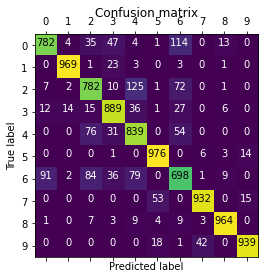

In [59]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predicted_labels)
plt.matshow(cm)
plt.title('Confusion matrix')
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] < thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
classes = range(10) # Labels are sorted 
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)
plt.show()

### Delete the end point

In [60]:
best_model_predictor.delete_endpoint()